# Detailed Example with Step by Step Procedure of Every Functions

This notebook serves as the demonstration in detail of every functions from the brief example demonstrated on 'Brief_EXAMPLE'.

## Initial Imports

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

## Part 1 (Essential): User Input & Pre-processing part
Load the necessary libraries for data processing, visualization, and mathematical operations. Load the battery data from the specified folder and perform initial grouping by cycles.

In [2]:
#----------------------------------Data input----------------------------------
data_folder = 'DA_Data'                                                        # <=== Insert folder of the data file(s)
result_folder = 'DA_Result'                                                    # <=== Insert folder for result
file_name = 'N1T1'                                                            # <=== Insert file name
rated_capacity = 2100                                                          # <=== Insert rated capacity of battery

### Data Import & Conditioning - DA00_Function_Import
First, start by looping through all the TXT files, then compile them into one DataFrame (df_main).

In [3]:
#-------------------------Inputs for this Function-------------------------
# data_folder,file_name,rated_capacity

# Import multiple Neware txt files, loop until all files found, remove 
# tab and header using skiprows, remove index and "." as decimal
    
df_main = []
i = 0  # Start counter

while True:
    # Correctly construct the file path
    file_path = f"{data_folder}/{file_name}/{file_name}__{i}.txt"
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Read the file
        dataraw = pd.read_csv(file_path, sep='\t', skiprows=0, index_col=False, decimal='.')
        df_main.append(dataraw)  # Append dataframe to the list
        i += 1  # Increment counter for the next file
    else:
        print(f"File {file_path} not found. Stopping.")
        break  # Exit loop when the file is not found

# Create one main dataframe by combining the loop import files
df_main = pd.concat(df_main, ignore_index=True)

File DA_Data/N1T1/N1T1__7.txt not found. Stopping.


Then, renaming the column label into simpler and non-sensitive naming, while also condition the data form into timedelta for 'Time' and process the 'Cycle_Time' as the time counter thoughout individual cycle.

In [4]:
# change column names
name_conversion_dict = {'Time(h:min:s.ms)': 'Time', 'Voltage(V)':'Voltage', 'Current(mA)': 'Current', 'Energy(mWh)': 'Energy', 'Capacity(mAh)': 'Capacity', 'dQ/dV(mAh/V)':'dQdV'}
df_main = df_main.rename(columns=name_conversion_dict)

# Convert 'Time' to timedelta (duration) for cumulative addition
df_main['Time'] = pd.to_timedelta(df_main['Time'].astype(str))
    
# Sort data properly: First by 'Cycle ID', then 'Record ID', then 'Time'
df_main = df_main.sort_values(by=['Cycle ID', 'Record ID', 'Time']).reset_index(drop=True)

# Compute Time difference within each cycle
df_main['Time_Diff'] = df_main.groupby('Cycle ID')['Time'].diff().fillna(pd.Timedelta(seconds=0))

# Ensure no negative values (set negatives to 0)
df_main['Time_Diff'] = df_main['Time_Diff'].apply(lambda x: max(x.total_seconds(), 0))  # Convert to milliseconds

# Compute Cycle_Time as the cumulative sum of Time_Diff within each cycle
df_main['Cycle_Time'] = df_main.groupby('Cycle ID')['Time_Diff'].cumsum() 

# Add 'Power' with multiplication of voltage and current
df_main.insert(df_main.columns.get_loc("Capacity") + 1, "Power", df_main["Voltage"] * df_main["Current"])
    
# DataFrame Preview
pd.set_option('display.max_columns', None)  # Show all columns   
print('DataFrame df_main preview: ',df_main.head(5))

DataFrame df_main preview:     Cycle ID  Step ID Step Name  Record ID                   Time  Voltage  \
0         1        1      Rest          1        0 days 00:00:00   3.5639   
1         1        1      Rest          2 0 days 00:00:00.100000   3.5639   
2         1        1      Rest          3 0 days 00:00:00.500000   3.5639   
3         1        1      Rest          4        0 days 00:00:01   3.5639   
4         1        1      Rest          5 0 days 00:00:01.500000   3.5639   

   Current  Capacity  Power  Energy             Realtime  dQdV  Time_Diff  \
0      0.0       0.0    0.0     0.0  10/18/2024 14:12:50   0.0        0.0   
1      0.0       0.0    0.0     0.0  10/18/2024 14:12:50   0.0        0.1   
2      0.0       0.0    0.0     0.0  10/18/2024 14:12:50   0.0        0.4   
3      0.0       0.0    0.0     0.0  10/18/2024 14:12:50   0.0        0.5   
4      0.0       0.0    0.0     0.0  10/18/2024 14:12:51   0.0        0.5   

   Cycle_Time  
0         0.0  
1         0.1 

### Data Grouping by Cycle - DA00_Function_df_Cycle_Grouping

From the compiled data, grouping by the cycle as one dataframe, and drop any unnecessary columns. Preview of DataFrame (df_cycle_grouped) is shown on the following output.

In [5]:
#-------------------------Inputs for this Function-------------------------
# df_main,result_folder,file_name

#Make result folder
os.makedirs(f"{result_folder}/{file_name}", exist_ok=True)  
print(f"Folder '{result_folder}/{file_name}' created!")

# Dropping unnecessary columns
df_cycle_grouped = df_main.drop(columns=['Time','Realtime','Time_Diff'])
    
# Grouping dataframe by Cycle ID, cycle_id = the cycle numbers
df_cycle_grouped = df_cycle_grouped.groupby('Cycle ID')
cycle_id = df_cycle_grouped.groups.keys()
print("The cycles imported from", file_name, "are:", cycle_id, "and pre-processed.")

pd.set_option('display.max_columns', None)  # Show all columns   
print('DataFrame df_cycle_grouped preview: ')
print(df_cycle_grouped.head(5))

Folder 'DA_Result/N1T1' created!
The cycles imported from N1T1 are: dict_keys([1, 2, 3, 4, 5]) and pre-processed.
DataFrame df_cycle_grouped preview: 
        Cycle ID  Step ID Step Name  Record ID  Voltage  Current  Capacity  \
0              1        1      Rest          1   3.5639     0.00      0.00   
1              1        1      Rest          2   3.5639     0.00      0.00   
2              1        1      Rest          3   3.5639     0.00      0.00   
3              1        1      Rest          4   3.5639     0.00      0.00   
4              1        1      Rest          5   3.5639     0.00      0.00   
73122          2        7    CC_Chg      73123   3.1420   419.89      0.00   
73123          2        7    CC_Chg      73124   3.1420   419.89      0.01   
73124          2        7    CC_Chg      73125   3.1482   419.95      0.06   
73125          2        7    CC_Chg      73126   3.1522   420.01      0.12   
73126          2        7    CC_Chg      73127   3.1547   420.01     

### Extract V & Cap data - DA00_Function_df_Cycle_Grouping

Another dataframe to extract voltage and capacity data, while beforehand make charge capacity continuous value between CC_Chg and CV_Chg by extracting the step through 'Step Name' column. The end capacity value of CC_Chg will be the starting capacity value for CV_Chg. Preview of DataFrame (df_VQ_grouped) is shown on the following output.

In [6]:
#-------------------------Inputs for this Function-------------------------
# df_cycle_grouped,result_folder,file_name

# Initialize an empty list to store data for each cycle
df_VQ_grouped_list = []

# Function to add CC_Chg to CV_Chg capacity (as initial capacity)
def accumulate_capacity(df, start_capacity):
    df['Accumulated_Capacity'] = df['Capacity'] + start_capacity
    return df

# Iterate over each cycle
for cycle_id, df_cyc in df_cycle_grouped:
        
    # Group by Step Name within each cycle
    df_step_grouped = df_cyc.groupby('Step Name')
    step_group_name = df_step_grouped.groups.keys()
       
    if 'CC_Chg' and 'CV_Chg' and 'CC_DChg' in step_group_name:
            
        # Extract relevant steps
        cc_chg = df_step_grouped.get_group('CC_Chg') if 'CC_Chg' in df_step_grouped.groups else pd.DataFrame()
        cv_chg = df_step_grouped.get_group('CV_Chg') if 'CV_Chg' in df_step_grouped.groups else pd.DataFrame()
        cc_dchg = df_step_grouped.get_group('CC_DChg') if 'CC_DChg' in df_step_grouped.groups else pd.DataFrame()
            
        # Voltage and Capacity for Charge steps
        vchg = pd.concat([cc_chg['Voltage'], cv_chg['Voltage']]) if not cv_chg.empty else cc_chg['Voltage']
        dqdvchg = pd.concat([cc_chg['dQdV'], cv_chg['dQdV']]) if not cv_chg.empty else cc_chg['dQdV']
        cchg_start = cc_chg['Capacity'].iloc[-1] if not cc_chg.empty else 0
        cchg = pd.concat([cc_chg['Capacity'], 
                          accumulate_capacity(cv_chg, cchg_start)['Accumulated_Capacity']]) if not cv_chg.empty else   cc_chg['Capacity']

        # Voltage and Capacity for Discharge steps
        vdchg = cc_dchg['Voltage'] if not cc_dchg.empty else pd.Series()
        cdchg = cc_dchg['Capacity'] if not cc_dchg.empty else pd.Series()
        dqdvdchg = cc_dchg['dQdV'] if not cc_dchg.empty else pd.Series()
        
        # Combine into a DataFrame for V-Q
        df_VQ = pd.DataFrame({
                f'Cycle_{cycle_id}_VChg': vchg.reset_index(drop=True),
                f'Cycle_{cycle_id}_CapChg': cchg.reset_index(drop=True),
                f'Cycle_{cycle_id}_dQdVChg': dqdvchg.reset_index(drop=True),
                f'Cycle_{cycle_id}_VDChg': vdchg.reset_index(drop=True),
                f'Cycle_{cycle_id}_CapDChg': cdchg.reset_index(drop=True),
                f'Cycle_{cycle_id}_dQdVDChg': dqdvdchg.reset_index(drop=True),
                })
               
        # Combine all the cycles
        df_VQ_grouped_list.append(df_VQ)

    else:
        continue
        
# Concatenate all cycle data horizontally and save the result
df_VQ_grouped = pd.concat(df_VQ_grouped_list, axis=1)
df_VQ_grouped.to_csv(f'{result_folder}/{file_name}/df_VQ_grouped_{file_name}.csv', index=False)
 
print('DataFrame df_VQ_grouped preview: ')
print(df_VQ_grouped.head(5))

C:\Users\hanst\AppData\Local\Temp\ipykernel_16736\3572163688.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Accumulated_Capacity'] = df['Capacity'] + start_capacity
C:\Users\hanst\AppData\Local\Temp\ipykernel_16736\3572163688.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Accumulated_Capacity'] = df['Capacity'] + start_capacity
C:\Users\hanst\AppData\Local\Temp\ipykernel_16736\3572163688.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

DataFrame df_VQ_grouped preview: 
   Cycle_1_VChg  Cycle_1_CapChg  Cycle_1_dQdVChg  Cycle_1_VDChg  \
0        3.6055            0.00             0.00         4.1372   
1        3.6055            0.01             0.00         4.1372   
2        3.6064            0.06            51.85         4.1369   
3        3.6070            0.12            97.23         4.1359   
4        3.6077            0.17            83.33         4.1356   

   Cycle_1_CapDChg  Cycle_1_dQdVDChg  Cycle_2_VChg  Cycle_2_CapChg  \
0             0.00              0.00        3.1420            0.00   
1             0.01              0.00        3.1420            0.01   
2             0.06           -155.56        3.1482            0.06   
3             0.12            -58.34        3.1522            0.12   
4             0.17           -194.44        3.1547            0.17   

   Cycle_2_dQdVChg  Cycle_2_VDChg  Cycle_2_CapDChg  Cycle_2_dQdVDChg  \
0             0.00         4.1378             0.00              0.00  

## Part 2 (Selective):  Plotting, Calculating, Processing, Analysis

All the functions that lead to plotting, calculating, processing, and analysis of degradation analysis with the metrics, such as Voltage to Capacity and dQ/dV analysis, however those functions are not related to each other and could be done independently and without order.

### Voltage and Current vs Time Analysis [Direct Plotting] - DA01_Function_VnIvsTime
Analyze the voltage and current vs time relationship across charge-discharge cycles. It is done on every cycle, one cycle one plot basis from the dataframe 'df_cycle_grouped'.

#### Inputs for this Function
- DataFrame: df_cycle_grouped
- User Inputs (String): file_name,result_folder
- All declared earlier or processed from Part 1 (Essential) phase.

Directly plotting Voltage and Current to time based on cycle (Cycle_Time) of every cycles based on the charging and discharging phase (continuously) from the DataFrame 'df_cycle_grouped'.

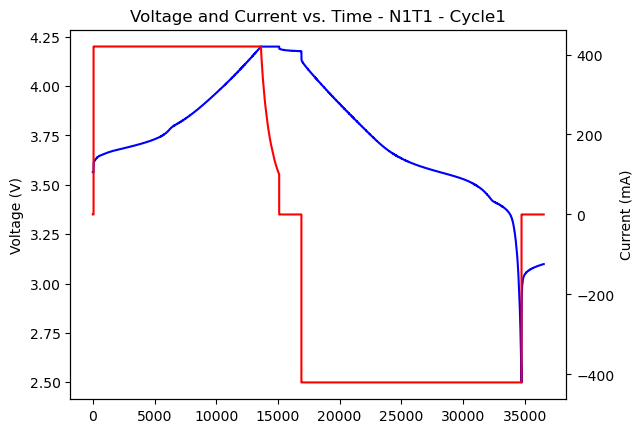

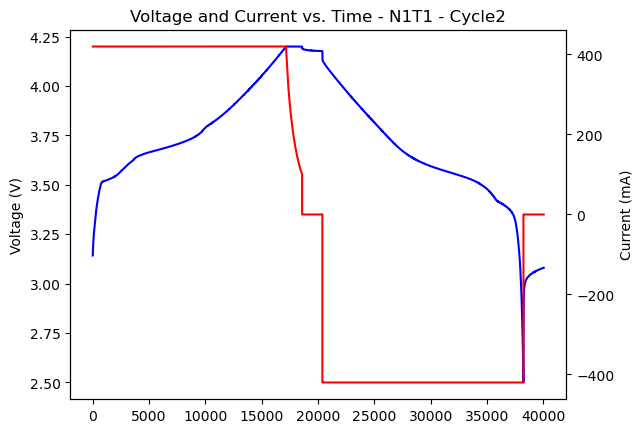

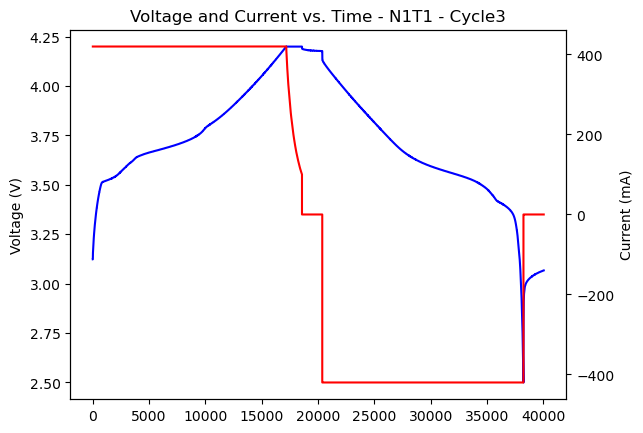

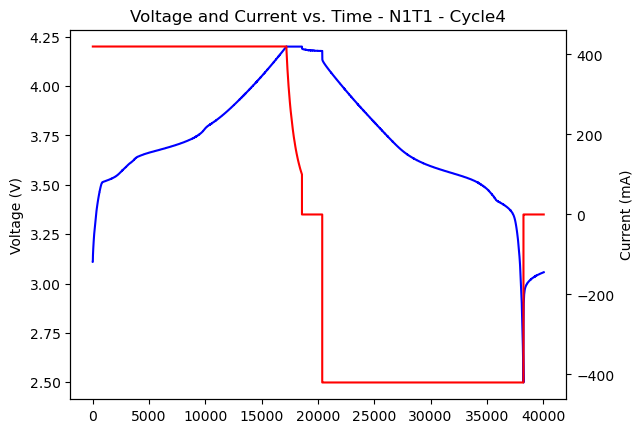

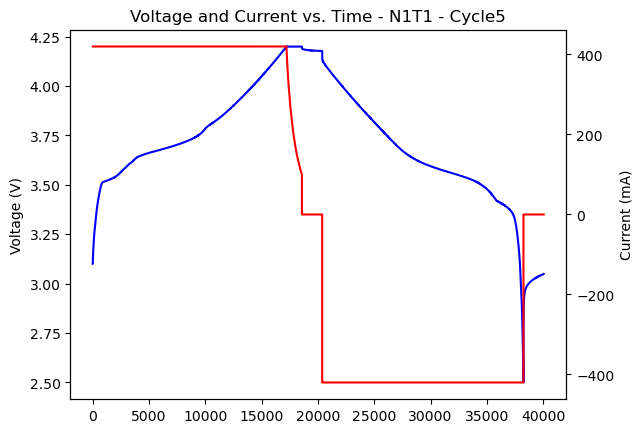

In [7]:
cycle_id = df_cycle_grouped.groups.keys()
    
#---------------------------------Every cycles----------------------------- 
i = 0
for i in cycle_id:    
    cycle_data = df_cycle_grouped.get_group(i)
    fig, host = plt.subplots()
    par1 = host.twinx()

    # Insert the data for overview plot
    p1, = host.plot(cycle_data['Cycle_Time'], cycle_data['Voltage'], "b-")
    p2, = par1.plot(cycle_data['Cycle_Time'], cycle_data['Current'], "r-")
    host.set_ylabel('Voltage (V)')
    par1.set_ylabel('Current (mA)')
    plt.title(f'Voltage and Current vs. Time - {file_name} - Cycle{i}')
    plt.savefig(f'{result_folder}/{file_name}/VnCvsTime_{file_name}_Cycle{i}.png', dpi=300, bbox_inches='tight')
    plt.show()
    i += 1

And also compiled all cycles in one battery cell into one plot.

C:\Users\hanst\AppData\Local\Temp\ipykernel_16736\3884448143.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  host.legend(loc='upper left')
C:\Users\hanst\AppData\Local\Temp\ipykernel_16736\3884448143.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  par1.legend(loc='upper right')


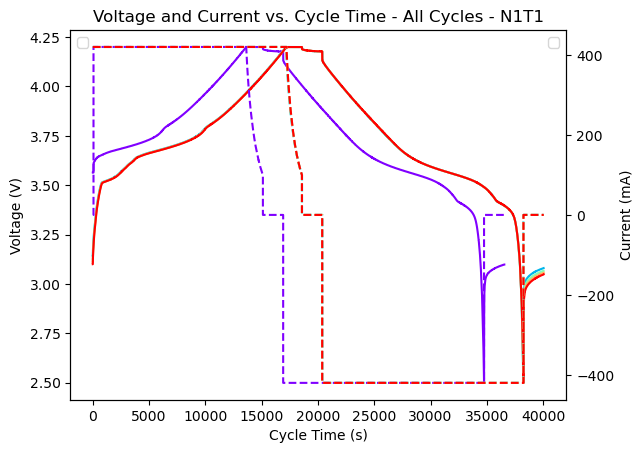

In [8]:
 #-----------------------------------All cycles-----------------------------    
fig, host = plt.subplots()
par1 = host.twinx()  # Create the second y-axis

# Get a colormap with enough colors for all cycles
colors = cm.rainbow(np.linspace(0, 1, len(cycle_id)))
    
i = 0
for i, cycle in enumerate(cycle_id):
    cycle_data = df_cycle_grouped.get_group(cycle)
      
    # Plot each cycle with a different color
    p1, = host.plot(cycle_data['Cycle_Time'], cycle_data['Voltage'], color=colors[i])#, label=f'Cycle {cycle} Voltage')
    p2, = par1.plot(cycle_data['Cycle_Time'], cycle_data['Current'], color=colors[i], linestyle='--')#, label=f'Cycle {cycle} Current')
    
# Set labels and titles
host.set_xlabel('Cycle Time (s)')
host.set_ylabel('Voltage (V)')
par1.set_ylabel('Current (mA)')
plt.title(f'Voltage and Current vs. Cycle Time - All Cycles - {file_name}')

# Create a legend that combines both axes
host.legend(loc='upper left')
par1.legend(loc='upper right')

# Save the combined plot
plt.savefig(f"{result_folder}/{file_name}/VnCvsTime_{file_name}_AllCycles.png", dpi=300, bbox_inches='tight')
plt.show()

### Power Analysis [Direct Plotting] - DA01_Function_Power

Analyze the power vs time relationship across charge-discharge cycles.

#### Inputs for this Function
- DataFrame: df_cycle_grouped
- User Inputs (String): file_name,result_folder
- All declared earlier or processed from Part 1 (Essential) phase.

Directly plotting Power to time based on cycle (Cycle_Time) of every cycles based on the charging and discharging phase (continuously) from the DataFrame 'df_cycle_grouped'.

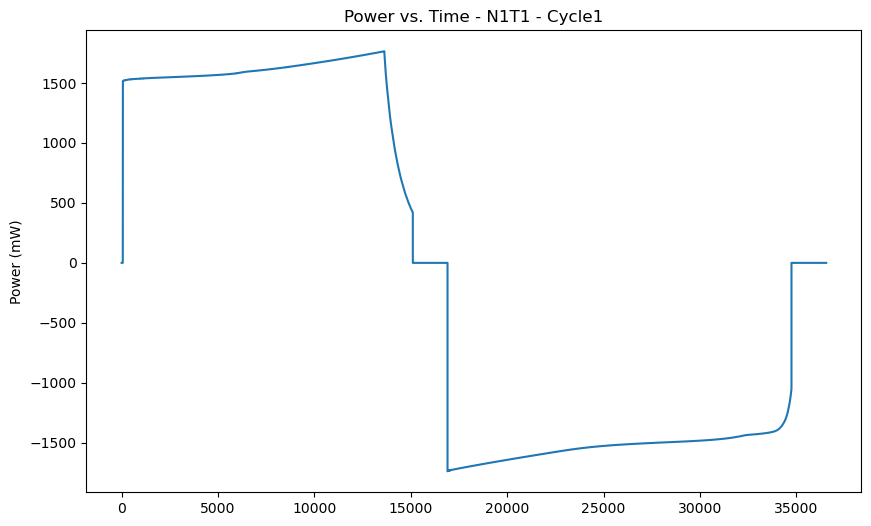

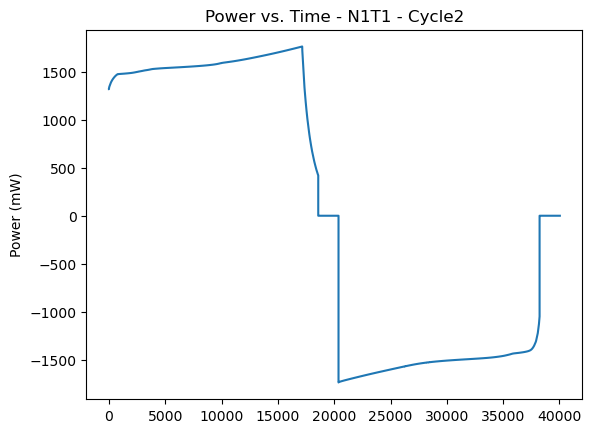

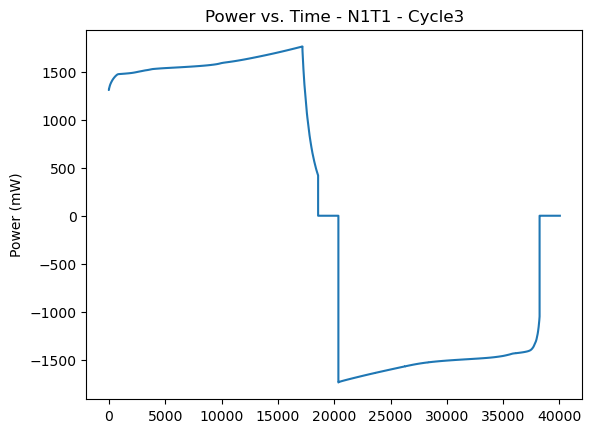

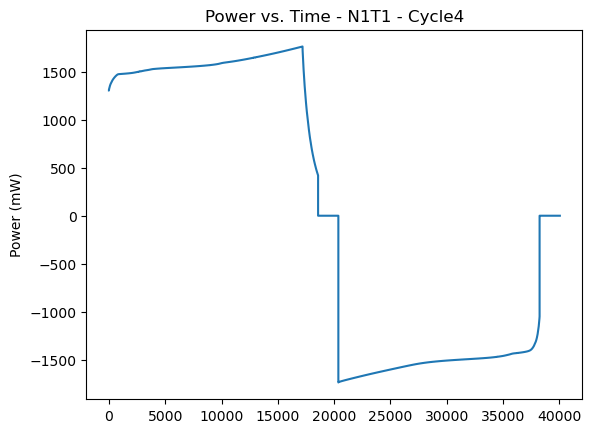

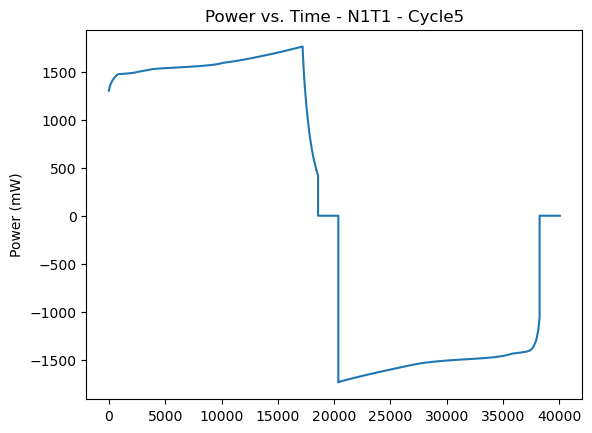

In [9]:
cycle_id = df_cycle_grouped.groups.keys()
    
#---------------------------------Every cycles----------------------------
plt.figure(figsize=(10, 6))
i = 0
for i in cycle_id:
    cycle_data = df_cycle_grouped.get_group(i)

    # Insert the data for overview plot
    plt.plot(cycle_data['Cycle_Time'], cycle_data['Power'])
    plt.ylabel('Cycle Time (s)')
    plt.ylabel('Power (mW)')
    plt.title(f'Power vs. Time - {file_name} - Cycle{i}')
    plt.savefig(f'{result_folder}/{file_name}/PvsTime_{file_name}_Cycle{i}.png', dpi=300, bbox_inches='tight')
    plt.show()
    i += 1

And also plot all cycles in one battery cell into one plot.

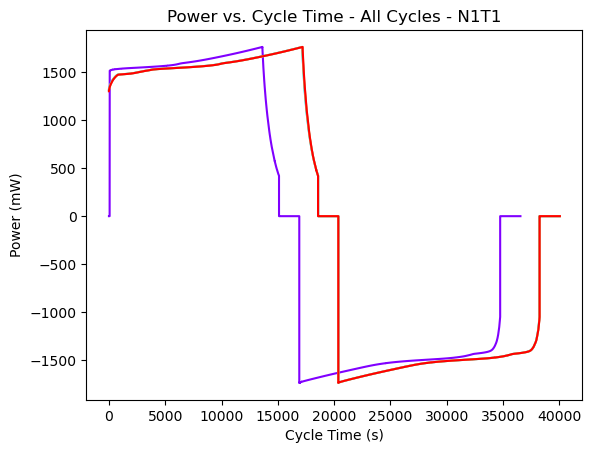

In [10]:
#-----------------------------------All cycles-----------------------------    
# Get a colormap with enough colors for all cycles
colors = cm.rainbow(np.linspace(0, 1, len(cycle_id)))

for i, cycle in enumerate(cycle_id):
    cycle_data = df_cycle_grouped.get_group(cycle)
        
    # Plot each cycle with a different color
    plt.plot(cycle_data['Cycle_Time'], cycle_data['Power'], color=colors[i])
    
# Set labels and titles
plt.xlabel('Cycle Time (s)')
plt.ylabel('Power (mW)')
plt.title(f'Power vs. Cycle Time - All Cycles - {file_name}')
plt.savefig(f"{result_folder}/{file_name}/PvsTime_{file_name}_AllCycles.png", dpi=300, bbox_inches='tight')
plt.show()

### Voltage vs Capacity Analysis [Direct Plotting] - DA02_Function_VvsCap

Analyze the voltage vs capacity relationship across charge-discharge cycles.

#### Inputs for this Function
- DataFrame: df_VQ_grouped
- User Inputs (String): file_name,result_folder,rated_capacity
- All declared earlier or processed from Part 1 (Essential) phase.

Directly plotting voltage to capacity of every cycles based on the charging and discharging phase from the DataFrame 'df_VQ_grouped'.

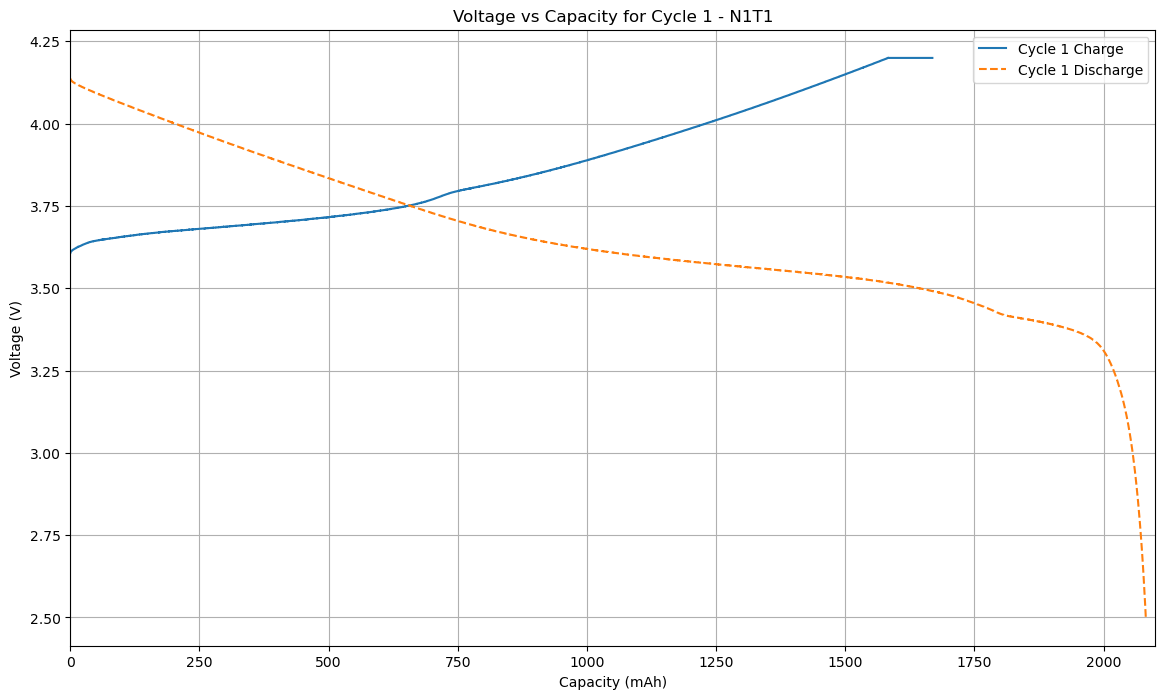

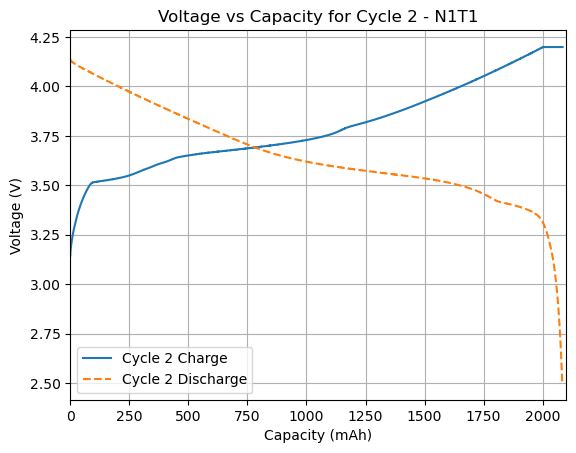

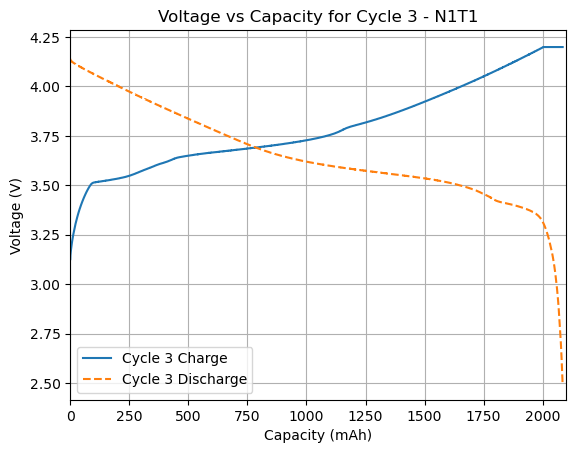

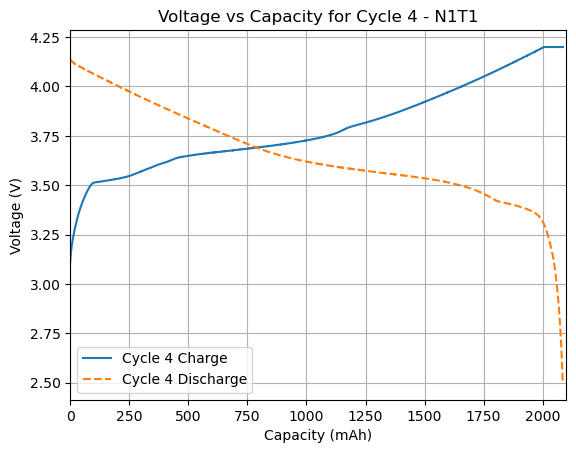

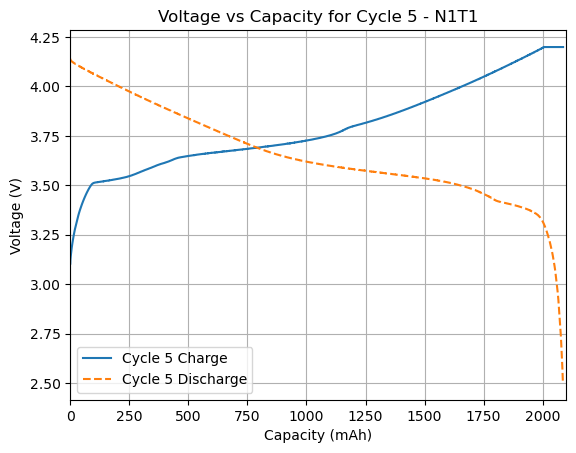

In [11]:
cycle_columns = [col for col in df_VQ_grouped.columns if re.match(r'Cycle_\d+_', col)]
cycle_numbers = sorted({int(re.search(r'Cycle_(\d+)_', col).group(1)) for col in cycle_columns})
    
#----------------------------Plot Every Cycles-----------------------------
plt.figure(figsize=(14, 8))

for idx, cycle_id in enumerate(cycle_numbers):

    # Plot Charge V-Q
    if f'Cycle_{cycle_id}_VChg' in df_VQ_grouped and f'Cycle_{cycle_id}_CapChg' in df_VQ_grouped:
        plt.plot(df_VQ_grouped[f'Cycle_{cycle_id}_CapChg'], 
                 df_VQ_grouped[f'Cycle_{cycle_id}_VChg'], label=f'Cycle {cycle_id} Charge')

    # Plot Discharge V-Q
    if f'Cycle_{cycle_id}_VDChg' in df_VQ_grouped and f'Cycle_{cycle_id}_CapDChg' in df_VQ_grouped:
        plt.plot(df_VQ_grouped[f'Cycle_{cycle_id}_CapDChg'],
                 df_VQ_grouped[f'Cycle_{cycle_id}_VDChg'], linestyle='--', 
                 label=f'Cycle {cycle_id} Discharge')
        
    plt.xlabel('Capacity (mAh)')
    plt.ylabel('Voltage (V)')
    plt.xlim(0, rated_capacity)
    plt.title(f'Voltage vs Capacity for Cycle {cycle_id} - {file_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{result_folder}/{file_name}/V-Q_Cycle_{cycle_id}_{file_name}.png')
    plt.show()

Similar curve trend should be seen on the plots, therefore, plot those all cycles on one plot to view the differences over the cycles.

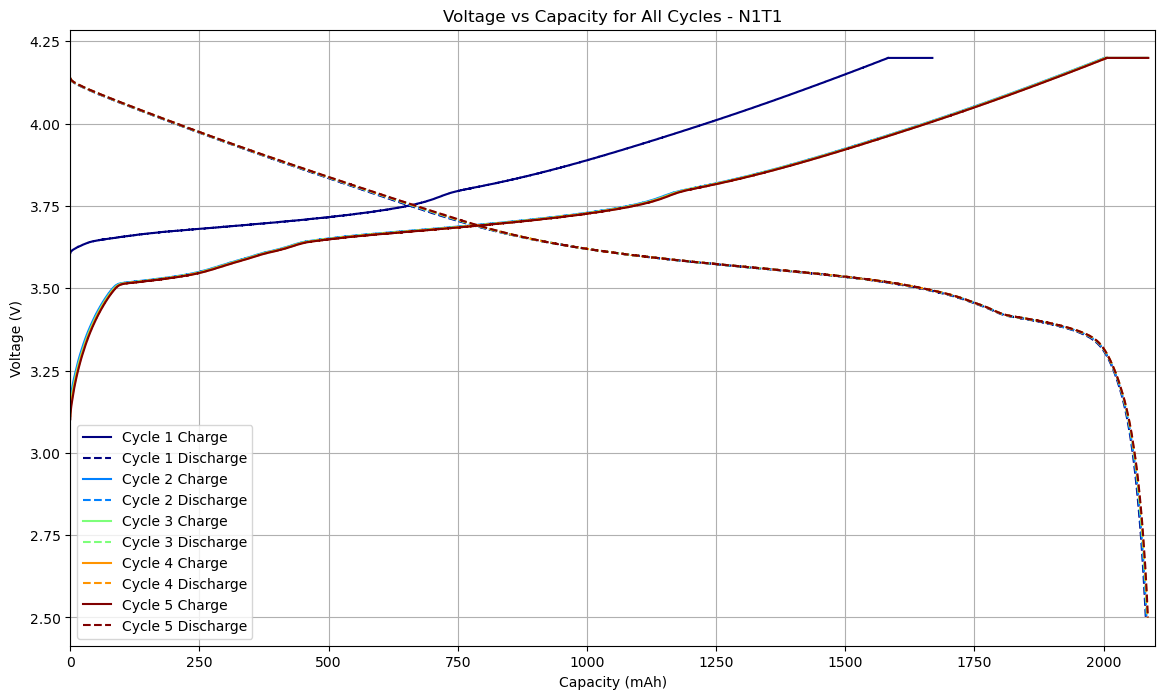

In [12]:
#-----------------------------Plot All Cycles------------------------------
# Plot V-Q for all cycles in one graph with different colors
plt.figure(figsize=(14, 8))

# Define a color map
colors = plt.cm.jet(np.linspace(0, 1, len(cycle_numbers)))

for idx, cycle_id in enumerate(cycle_numbers):
    color = colors[idx]

    # Plot Charge V-Q
    if f'Cycle_{cycle_id}_VChg' in df_VQ_grouped and f'Cycle_{cycle_id}_CapChg' in df_VQ_grouped:
        plt.plot(df_VQ_grouped[f'Cycle_{cycle_id}_CapChg'], 
                 df_VQ_grouped[f'Cycle_{cycle_id}_VChg'], label=f'Cycle {cycle_id} Charge', 
                 color=color)

    # Plot Discharge V-Q
    if f'Cycle_{cycle_id}_VDChg' in df_VQ_grouped and f'Cycle_{cycle_id}_CapDChg' in df_VQ_grouped:
        plt.plot(df_VQ_grouped[f'Cycle_{cycle_id}_CapDChg'],
                 df_VQ_grouped[f'Cycle_{cycle_id}_VDChg'], linestyle='--', 
                 label=f'Cycle {cycle_id} Discharge', color=color)

plt.xlabel('Capacity (mAh)')
plt.ylabel('Voltage (V)')
plt.xlim(0, rated_capacity)
plt.title(f'Voltage vs Capacity for All Cycles - {file_name}')
plt.legend()
plt.grid(True)
plt.savefig(f'{result_folder}/{file_name}/V-Q_All_Cycles_{file_name}.png')   
plt.show()

The curve differences between the colors shows the change progress over cycles. Wider gap between the colors shows the more distinctive condition between the cycles.

### Coulombic Efficiency (CE) Analysis [Processing & Plotting] - DA03_Function_Coulombic_Efficiency

#### Inputs for this Function
- DataFrame: df_VQ_grouped
- User Inputs (String): file_name,result_folder
- All declared earlier or processed from Part 1 (Essential) phase.

Calculate the coulombic efficiency of the battery over cycles by dividing maximum discharging capacity by maximum charging capacity. Preview of DataFrame (df_ce) is shown on the following output.

In [13]:
ce_cycle = []
    
# Extract unique cycle numbers from the column names
cycle_columns = [col for col in df_VQ_grouped.columns if re.match(r'Cycle_\d+_', col)]
cycle_numbers = sorted({int(re.search(r'Cycle_(\d+)_', col).group(1)) for col in cycle_columns})

for cycle_id in cycle_numbers:
       
    cchg = df_VQ_grouped[f'Cycle_{cycle_id}_CapChg'].dropna()
    cdchg = df_VQ_grouped[f'Cycle_{cycle_id}_CapDChg'].dropna()
      
    # Calculate Coulombic Efficiency (CE)
    total_CapChg = cchg.iloc[-1] if not cchg.empty else 0
    total_CapDChg = cdchg.iloc[-1] if not cdchg.empty else 0
    ce = (total_CapDChg / total_CapChg) * 100 if total_CapChg > 0 else 0
    if ce > 100:
        continue
        
    # Combine into a DataFrame
    ce_cycle.append({
        'Cycle_ID': cycle_id,
        'Discharge_Capacity': total_CapDChg,
        'Charge_Capacity': total_CapChg,
        'Coulombic_Efficiency': ce,
        })
               
# Create a DataFrame for Coulombic Efficiencies and save the result
df_ce = pd.DataFrame(ce_cycle)
df_ce.to_csv(f'{result_folder}/{file_name}/df_CE_{file_name}.csv', index=False)
pd.set_option('display.max_columns', None)  # Show all columns   
print('DataFrame df_ce preview: ')
print(df_ce.head(5))

DataFrame df_ce preview: 
   Cycle_ID  Discharge_Capacity  Charge_Capacity  Coulombic_Efficiency
0         2             2082.97          2084.35             99.933792
1         3             2084.21          2084.74             99.974577
2         4             2085.16          2085.93             99.963086
3         5             2085.69          2086.50             99.961179


The dataframe output have complete information about the coulombic efficiency, including the charge and discharge capacity on the corresponding cycle. To visualize the trend better, plotting the coulombic efficiency of the battery over cycles with the maximum charging and discharging capacity over cycle on the other y axis (y-axis 2). The plot shows the percentage of efficiency along the cycles in one plot.

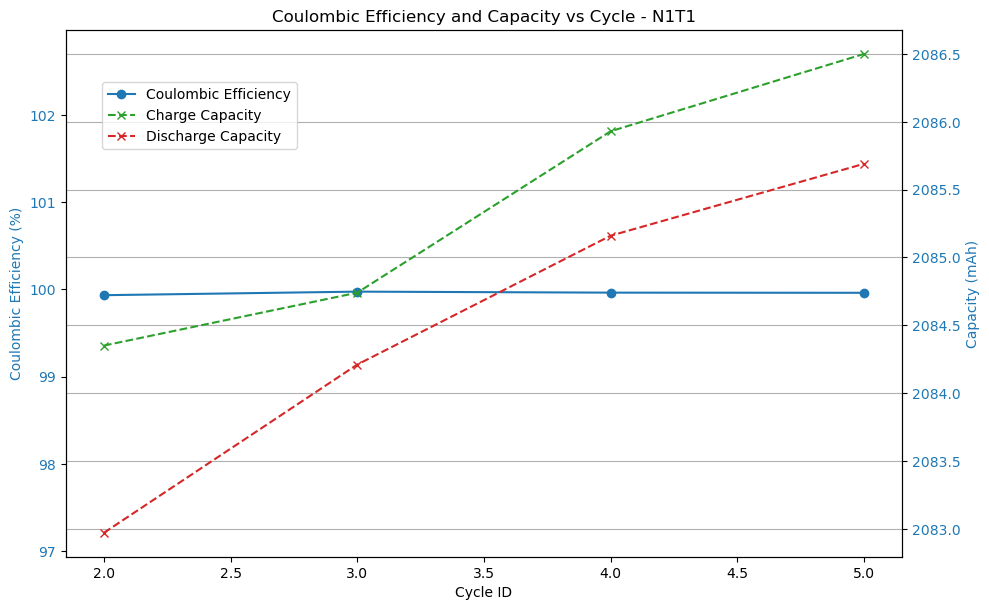

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Cycle ID')
ax1.set_ylabel('Coulombic Efficiency (%)', color=color)
ax1.plot(df_ce['Cycle_ID'], df_ce['Coulombic_Efficiency'], color=color, 
         marker='o', label='Coulombic Efficiency')
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim((df_ce['Coulombic_Efficiency'].min()*0.97), (df_ce['Coulombic_Efficiency'].max()*1.03))

ax2 = ax1.twinx()
ax2.set_ylabel('Capacity (mAh)', color=color)
ax2.plot(df_ce['Cycle_ID'], df_ce['Charge_Capacity'], color='tab:green', 
         marker='x', linestyle='--', label='Charge Capacity')
ax2.plot(df_ce['Cycle_ID'], df_ce['Discharge_Capacity'], color='tab:red', 
         marker='x', linestyle='--', label='Discharge Capacity')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.title(f'Coulombic Efficiency and Capacity vs Cycle - {file_name}')
plt.grid(True)
plt.savefig(f'{result_folder}/{file_name}/CE-cycles_{file_name}.png', dpi=300)
plt.show()

The difference of efficiency level might not be very visible without zooming in the scale of the data, with 3% excess from the data maximum and minimum .

### State of Health (SOH) Analysis [Processing & Plotting] - DA04_Function_SOH

#### Inputs for this Function

- DataFrame: df_VQ_grouped
- User Inputs (String): rated_capacity,file_name,result_folder
- All declared earlier or processed from Part 1 (Essential) phase.

Calculate and visualize the state of health of the battery over cycles. Preview of DataFrame (df_SOH) is shown on the following output.

In [15]:
SOH_data = []
    
# Extract unique cycle numbers from the column names
cycle_columns = [col for col in df_VQ_grouped.columns if re.match(r'Cycle_\d+_', col)]
cycle_numbers = sorted({int(re.search(r'Cycle_(\d+)_', col).group(1)) for col in cycle_columns})

for cycle_id in cycle_numbers:
       
    cchg = df_VQ_grouped[f'Cycle_{cycle_id}_CapChg'].dropna()
    cdchg = df_VQ_grouped[f'Cycle_{cycle_id}_CapDChg'].dropna()
        
    # Calculate SOH
    if cchg.max() > cdchg.max():
        max_capacity_per_cycle = cchg.max()
    else:
        max_capacity_per_cycle = cdchg.max()
            
    soh = (max_capacity_per_cycle / rated_capacity) * 100
        
    # Combine into a DataFrame
    SOH_data.append({
            'Cycle_ID': cycle_id,
            'Maximum_Capacity': max_capacity_per_cycle,
            'SOH': soh
            })
    
df_SOH = pd.DataFrame(SOH_data)
df_SOH.to_csv(f'{result_folder}/{file_name}/df_SOH_{file_name}.csv', index=False)
pd.set_option('display.max_columns', None)  # Show all columns   
print('DataFrame df_SOH preview: ')
print(df_SOH.head(5))

DataFrame df_SOH preview: 
   Cycle_ID  Maximum_Capacity        SOH
0         1           2081.65  99.126190
1         2           2084.35  99.254762
2         3           2084.74  99.273333
3         4           2085.93  99.330000
4         5           2086.50  99.357143


The dataframe output have complete information about the SOH per cycles, including the maximum capacity achieved on the corresponding cycle. To visualize the trend better, plotting the SOH percentage of the battery over cycles. The plot shows the percentage of SOH along the cycles in one plot.

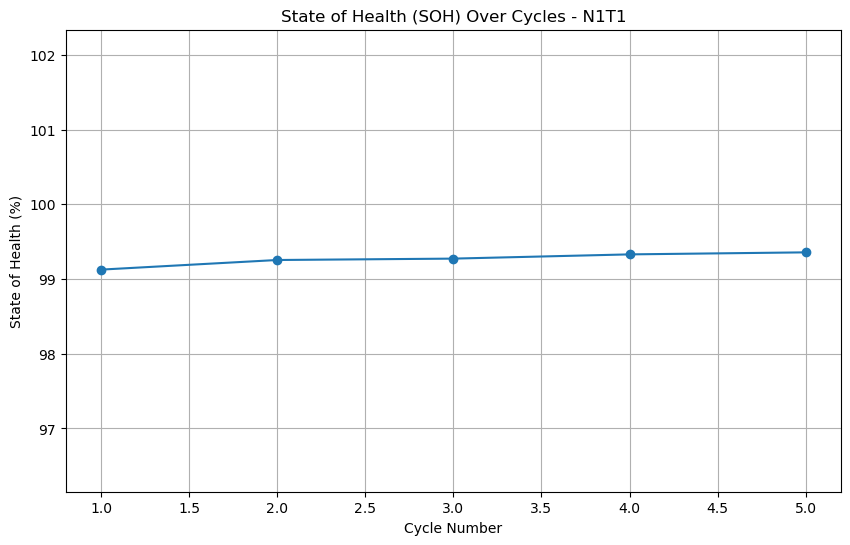

In [16]:
plt.figure(figsize=(10,6))
plt.plot(df_SOH['Cycle_ID'], df_SOH['SOH'], marker='o')
plt.xlabel('Cycle Number')
plt.ylabel('State of Health (%)')
plt.ylim((df_SOH['SOH'].min()*0.97), (df_SOH['SOH'].max()*1.03))
plt.title(f'State of Health (SOH) Over Cycles - {file_name}')
plt.grid(True)
plt.savefig(f'{result_folder}/{file_name}/SOH Plot_{file_name}.png', dpi=300)
plt.show()

The difference of SOH percentage might not be very visible without zooming in the scale of the data, with 3% excess from the data maximum and minimum .

### dQ/dV Analysis [Processing, Analysis, Plotting] - DA06_Function_dQdV

Perform dQ/dV analysis to study capacity degradation trends.

#### Calculation, Interpolation, Smoothing, Plotting of dQ/dV

##### Inputs for this Function

- DataFrame: df_VQ_grouped
- User Inputs (String): file_name,result_folder
- All declared earlier or processed from Part 1 (Essential) phase.

Declaring the inputs and functions needed.

In [ ]:
# Selecting parameters shown on plot
show_on_plot = [                                                           # <=== Insert the parameters to be shown on the plot: 
               # 'data'                                                    #      - 'data':from neware;
               'ori',                                                     #      - 'ori':pure calculation; 
               'int',                                                     #      - 'int':interpolated data; 
               'smooth',                                                  #      - 'smooth':interpolation,then filtering/smoothing  
                                                                          #         with Savitzky-Golay filter; 
               'peaks-fitting'                                            #      - 'peaks-fitting':notate peaks and plot Gaussian 
                                                                          #         fitting curve on the plot             
                ]

# Interpolation setup
interpolation_points = 300                                               # <=== Insert data point numbers for interpolation

# Smoothing setup               [Setup for Savitzky–Golay filter smoothing]
window_length = 5                                                        # <=== Insert the window length as the smoothing properties
polyorder = 1                                                            # <=== Insert the polyorder as the smoothing properties

#----------------------------------Functions-----------------------------------
# Function of interpolation to reduce data points
def interpolate_data(x, y, num_points):
    if len(x) < 2 or len(y) < 2:
        return x, y  # No interpolation possible
    interpolation_func = interp1d(x, y, kind='linear')
    new_x = np.linspace(np.min(x), np.max(x), num_points)
    new_y = interpolation_func(new_x)
    return new_x, new_y

# Function to smooth data using Savitzky-Golay filter
def smooth_data(y,window_length,polyorder):
    if len(y) < 3:
        return y  # Not enough data to smooth
    return savgol_filter(y,window_length,polyorder)

#-----------------Initiation: create DataFrame & call Cycle ID-----------------   
# Create DataFrames
dqdv_data = []
df_dqdv_data = []

# Extract unique cycle numbers from the column names
cycle_columns = [col for col in df_VQ_grouped.columns if re.match(r'Cycle_\d+_', col)]
cycle_numbers = sorted({int(re.search(r'Cycle_(\d+)_', col).group(1)) for col in cycle_columns})

First step is the interpolation of voltage and capacity data, then calculate dQ/dV by derivating capacity by voltage based on the dataframe 'df_VQ_grouped'.

In [18]:
#---------------Calculating & Smoothing dQ/dV, Plotting per Cycle--------------
for cycle_id in cycle_numbers:

    #-------------------------------On Charging--------------------------------
    if f'Cycle_{cycle_id}_CapChg' in df_VQ_grouped and f'Cycle_{cycle_id}_VChg' in df_VQ_grouped and f'Cycle_{cycle_id}_dQdVChg' in df_VQ_grouped:
        capchg = df_VQ_grouped[f'Cycle_{cycle_id}_CapChg'].dropna()
        vchg = df_VQ_grouped[f'Cycle_{cycle_id}_VChg'].dropna()
        dqdvchg = df_VQ_grouped[f'Cycle_{cycle_id}_dQdVChg'].dropna()
            
        # Interpolate data
        vchg_interp, capchg_interp = interpolate_data(vchg,capchg,interpolation_points)
            
        # Calculate dQ/dV
        dQdV_chg_ori = np.diff(capchg) / np.diff(vchg)
        dQdV_chg_int = np.diff(capchg_interp) / np.diff(vchg_interp)
        dQdV_chg_smooth = smooth_data(dQdV_chg_int,window_length,polyorder)
           
        # Combine those data into dataframe
        dqdv_data = pd.DataFrame({
                f'Cycle_{cycle_id}_VChg': vchg_interp[:-1],
                # f'Cycle_{cycle_id}_dQdVChg_int': dQdV_chg_int,
                f'Cycle_{cycle_id}_dQdVChg_Smooth': dQdV_chg_smooth
                })
        df_dqdv_data.append(dqdv_data)
            
    #-----------------------------On Discharging-------------------------------
    if f'Cycle_{cycle_id}_CapDChg' in df_VQ_grouped and f'Cycle_{cycle_id}_VDChg' in df_VQ_grouped and f'Cycle_{cycle_id}_dQdVDChg' in df_VQ_grouped:
        capdchg = df_VQ_grouped[f'Cycle_{cycle_id}_CapDChg'].dropna()
        vdchg = df_VQ_grouped[f'Cycle_{cycle_id}_VDChg'].dropna()
        dqdvdchg = df_VQ_grouped[f'Cycle_{cycle_id}_dQdVDChg'].dropna()
            
        # Interpolate data
        vdchg_interp, capdchg_interp = interpolate_data(vdchg,capdchg,interpolation_points)
            
        # Calculate dQ/dV on interpolated data
        dQdV_dchg_ori = np.diff(capdchg) / np.diff(vdchg)
        dQdV_dchg_int = np.diff(capdchg_interp) / np.diff(vdchg_interp)
        dQdV_dchg_smooth = smooth_data(dQdV_dchg_int,window_length,polyorder)
            
        # Combine those data into dataframe
        dqdv_data = pd.DataFrame({
                f'Cycle_{cycle_id}_VDChg': vdchg_interp[:-1],
                # f'Cycle_{cycle_id}_dQdVDChg_int': dQdV_dchg_int,
                f'Cycle_{cycle_id}_dQdVDChg_Smooth': dQdV_dchg_smooth
                })
        df_dqdv_data.append(dqdv_data)

C:\Users\hanst\AppData\Local\Temp\ipykernel_16736\3883174974.py:14: RuntimeWarning: divide by zero encountered in divide
  dQdV_chg_ori = np.diff(capchg) / np.diff(vchg)
C:\Users\hanst\AppData\Local\Temp\ipykernel_16736\3883174974.py:36: RuntimeWarning: divide by zero encountered in divide
  dQdV_dchg_ori = np.diff(capdchg) / np.diff(vdchg)


Then, plotting was done to visualize the dQ/dV, either the original calculated data, interpolated, and/or smoothed data. It was free to select which to be viewed.

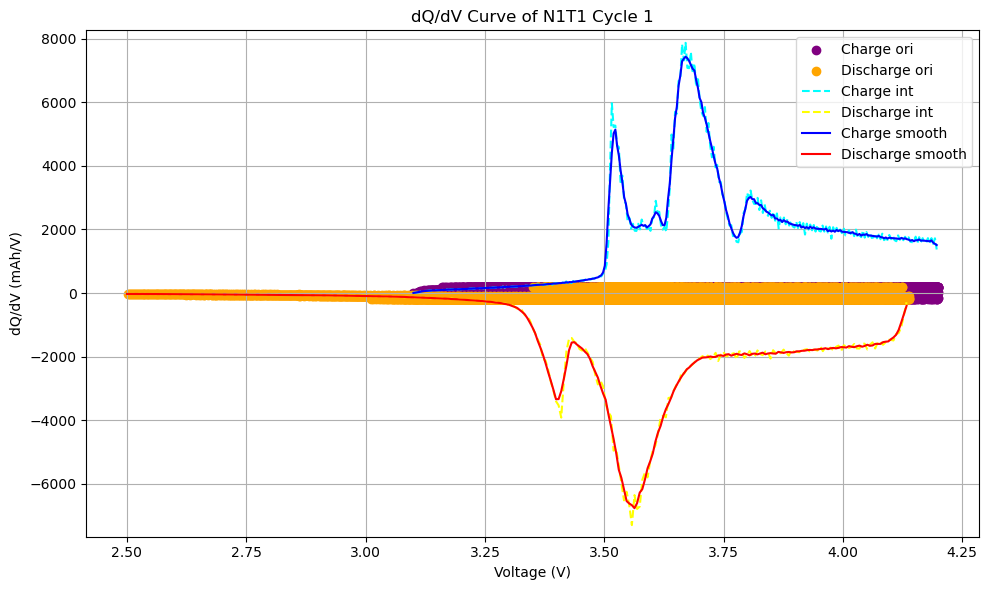

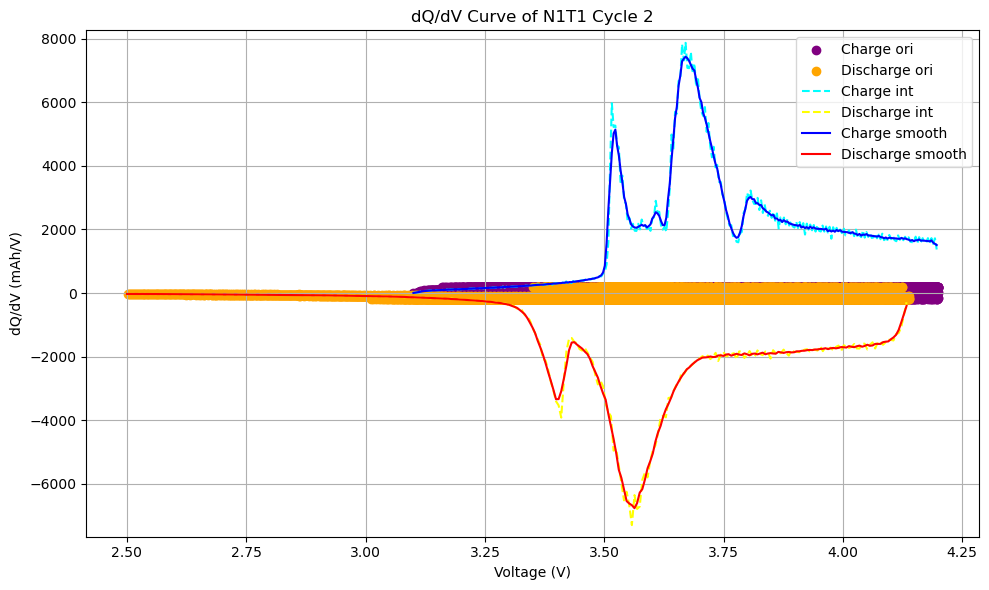

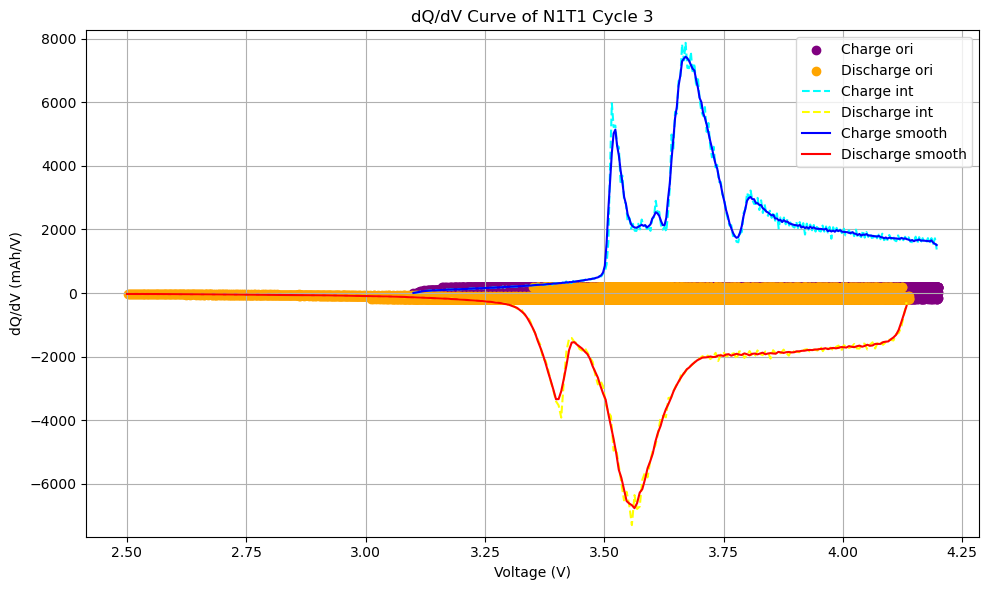

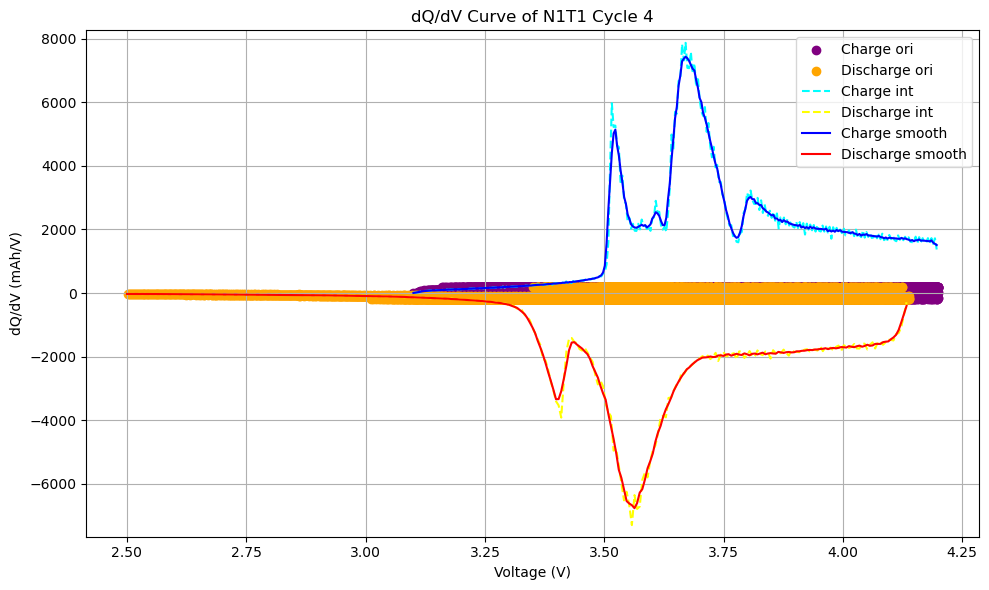

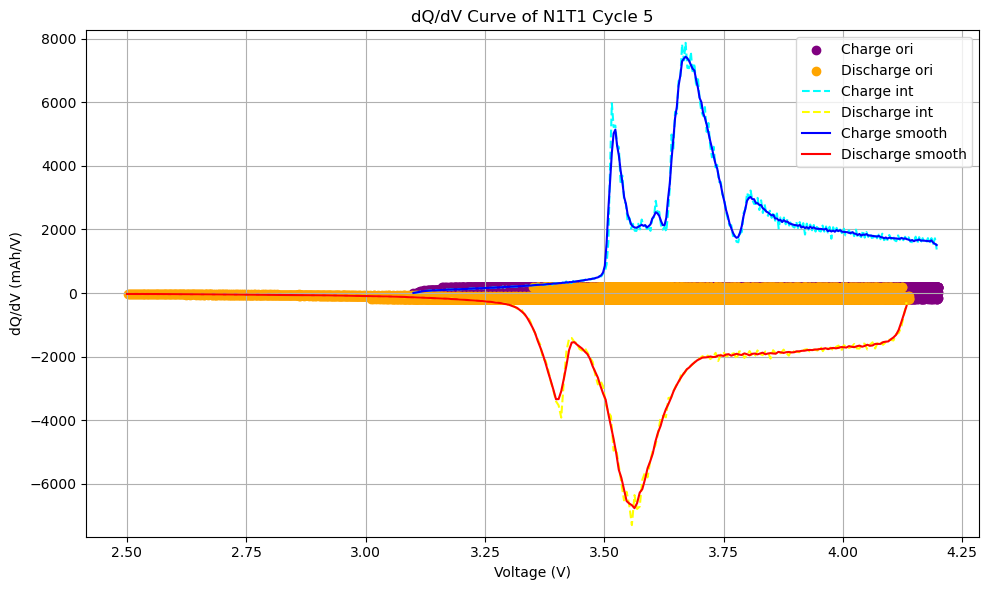

In [19]:
#----------------------------Plotting per cycle----------------------------
for cycle_id in cycle_numbers:    
    # Plotting dQ/dV vs Voltage
    if 'data' or 'ori' or 'int' or 'smooth' in show_on_plot:
        plt.figure(figsize=(10, 6))
     
        # Plot dQ/dV data from Neware
        if 'data' in show_on_plot:
            plt.plot(vchg, dqdvchg, label='Charge data', linestyle='--', color='purple')
            plt.plot(vdchg, dqdvdchg, label='Discharge data', linestyle='--', color='orange')
                
        # Plot calculated dQ/dV 
        if 'ori' in show_on_plot:
            plt.scatter(vchg[:-1], dQdV_chg_ori, label='Charge ori', color='purple')
            plt.scatter(vdchg[:-1], dQdV_dchg_ori, label='Discharge ori', color='orange')
                     
        # Plot interpolated dQ/dV
        if 'int' in show_on_plot:
            plt.plot(vchg_interp[:-1], dQdV_chg_int, label='Charge int', linestyle='--', color='cyan')
            plt.plot(vdchg_interp[:-1], dQdV_dchg_int, label='Discharge int', linestyle='--', color='yellow')
                
        # Plot smoothed dQ/dV
        if 'smooth' in show_on_plot:
            plt.plot(vchg_interp[:-1], dQdV_chg_smooth, label='Charge smooth', color='blue')
            plt.plot(vdchg_interp[:-1], dQdV_dchg_smooth, label='Discharge smooth', color='red')
        
        plt.xlabel('Voltage (V)')
        plt.ylabel('dQ/dV (mAh/V)')
        plt.ylim((dQdV_dchg_int.min()*1.05), (dQdV_chg_int.max()*1.05))
        plt.title(f'dQ/dV Curve of {file_name} Cycle {cycle_id}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'{result_folder}/{file_name}/dQdV_{file_name}_Cycle_{cycle_id}.png', dpi=300)
        plt.show()
            
    else:
        continue

Then, export the dQ/dV smoothed data for further analysis. The following output showed the preview on the DataFrame 'df_dqdv', with voltage and dQ/dV smoothed data, differentiated on cycle ID and phase (charging or discharging).

In [20]:
# Export the dQ/dV data to a CSV
df_dqdv = pd.concat(df_dqdv_data, axis=1)
df_dqdv.to_csv(f'{result_folder}/{file_name}/df_dQdV_{file_name}.csv', index=False)
print("dQ/dV data saved successfully to",f'{result_folder}/{file_name}/df_dQdV_{file_name}.csv')
pd.set_option('display.max_columns', None)  # Show all columns   
print('DataFrame df_dqdv preview: ')
print(df_dqdv.head(5))

dQ/dV data saved successfully to DA_Result/N1T1/df_dQdV_N1T1.csv
DataFrame df_dqdv preview: 
   Cycle_1_VChg  Cycle_1_dQdVChg_Smooth  Cycle_1_VDChg  \
0      3.605500               99.441321       2.499300   
1      3.607489              252.231592       2.504778   
2      3.609477              405.021863       2.510256   
3      3.611466              567.935066       2.515734   
4      3.613455              746.104945       2.521212   

   Cycle_1_dQdVDChg_Smooth  Cycle_2_VChg  Cycle_2_dQdVChg_Smooth  \
0               -28.917960      3.142000                2.188525   
1               -29.847791      3.145539               11.998423   
2               -30.777622      3.149078               21.808321   
3               -31.282851      3.152616               31.101711   
4               -31.882824      3.156155               43.231705   

   Cycle_2_VDChg  Cycle_2_dQdVDChg_Smooth  Cycle_3_VChg  \
0       2.500000               -30.286762      3.123100   
1       2.505478               

Visualization of all cycles into one plot was also done to analyze the different conditions along the cycles.

C:\Users\hanst\AppData\Local\Temp\ipykernel_16736\1077727717.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


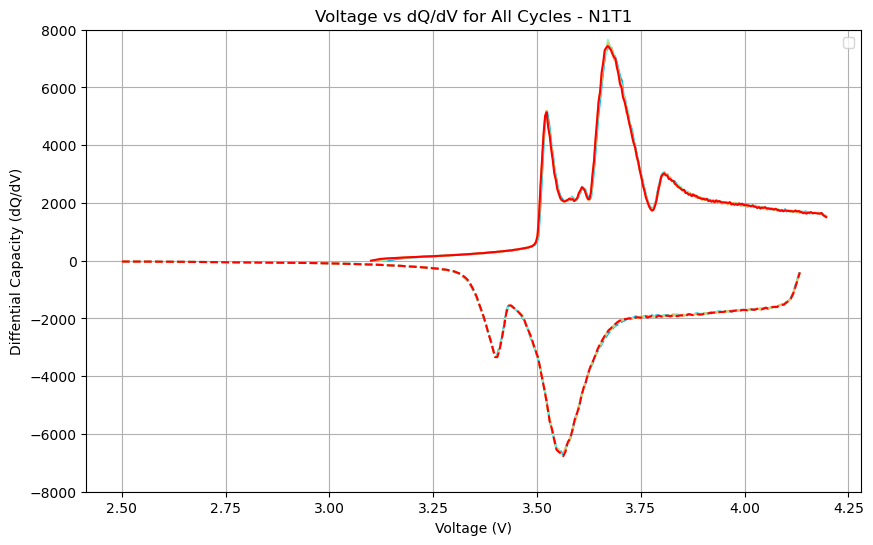

In [21]:
#-----------------------------Plot all cycles----------------------------------       
# Create the plot with a rainbow color map, all cycles
colors = plt.cm.rainbow(np.linspace(0, 1, len(cycle_numbers)))
plt.figure(figsize=(10, 6))
    
for idx, cycle_id in enumerate(cycle_numbers):
    color = colors[idx]
    if cycle_id == 1:
        cycle_id = 2
        idx = 2
    else :
        #---------------------------On Charging----------------------------
        if f'Cycle_{cycle_id}_VChg' in df_dqdv and f'Cycle_{cycle_id}_dQdVChg_Smooth' in df_dqdv:
            plt.plot(df_dqdv[f'Cycle_{cycle_id}_VChg'], 
                     df_dqdv[f'Cycle_{cycle_id}_dQdVChg_Smooth'],color=color)

        #--------------------------On Discharging--------------------------
        if f'Cycle_{cycle_id}_VDChg' in df_dqdv and f'Cycle_{cycle_id}_dQdVDChg_Smooth' in df_dqdv:
            plt.plot(df_dqdv[f'Cycle_{cycle_id}_VDChg'],
                     df_dqdv[f'Cycle_{cycle_id}_dQdVDChg_Smooth'], 
                     linestyle='--', color=color)

plt.xlabel('Voltage (V)')
plt.ylabel('Diffential Capacity (dQ/dV)')
plt.ylim(-8000, 8000)
plt.title(f'Voltage vs dQ/dV for All Cycles - {file_name}')
plt.legend()
plt.grid(True)
plt.savefig(f'{result_folder}/{file_name}/All_Cycles_dQdV_{file_name}.png')
plt.show()

#### Finding Peaks

##### Inputs for this Function

- The smoothed dQ/dV data 'df_dqdv'
- User Inputs (String): file_name; result_folder; prominence (min & max, step); height (min & max, step); maximum iterations (max_iterations); maximum peaks expected (max_peaks)
- All declared or processed from previous function.

Initiated by the input of parameters for the function.

In [22]:
# Finding peaks setup   [Setup parameter for finding peaks on dQ/dV-V plot]
min_prominence = 50                       #[Do not change if not necessary] <=== Insert the minimum prominence value
min_height = 50                           #[Do not change if not necessary] <=== Insert the minimum height value
max_prominence = 10000                    #[Do not change if not necessary] <=== Insert the maximum prominence value
max_height = 10000                        #[Do not change if not necessary] <=== Insert the maximum height value
prominence_step = 10                      #[Do not change if not necessary] <=== Insert the prominence value per iteration 
height_step = 10                          #[Do not change if not necessary] <=== Insert the height value per iteration            
max_iterations = 1000                     #[Do not change if not necessary] <=== Insert the maximum iteration number
max_peaks = 2                             #[Do not change if not necessary] <=== Insert the maximum expected peaks

# Create DataFrames
df_peaks_data = []

Peak finding was done using 'find_peaks' method from the 'scipy.signal' library. The output was the detected peaks (voltage and the dQ/dV values). The following output will show the preview of the DataFrame containing the result.

In [23]:
#-----------------------Peaks finding-----------------------
# Plot Charge dQ/dV with significant peaks
if 'peaks-fitting' in show_on_plot:
    for cycle_id in cycle_numbers:
        #---------------------------On Charging----------------------------
        height_range = min_height
        prominence_range = min_prominence
        Chg_peak_indices = []
        iterations = 0
        dqdv_chg_smooth = df_dqdv[f'Cycle_{cycle_id}_dQdVChg_Smooth']
        print(dqdv_chg_smooth)
        v_chg_smooth = df_dqdv[f'Cycle_{cycle_id}_VChg']
            
        # Looping height and prominence from minimum value for flexibility
        while (len(Chg_peak_indices) > max_peaks or len(Chg_peak_indices) == 0) and iterations < max_iterations:
            print(f"Iteration {iterations}: len(Chg_peak_indices) = {len(Chg_peak_indices)}, height_range = {height_range}, prominence_range = {prominence_range}")
    
            # Detect peaks
            Chg_peak_indices, _ = find_peaks(dqdv_chg_smooth, height=height_range, prominence=prominence_range)
    
            # Adjust height and prominence based on the number of detected peaks
            if len(Chg_peak_indices) > max_peaks:
                print("Detected more than 2 peaks; increasing thresholds")
                height_range = min(height_range + height_step, max_height)
                prominence_range = min(prominence_range + prominence_step, max_prominence)
            elif len(Chg_peak_indices) == 0:
                print("No peaks detected; decreasing thresholds")
                height_range = max(height_range - height_step, min_height)
                prominence_range = max(prominence_range - prominence_step, min_prominence)
    
            iterations += 1     # Increment iteration count
            
        # Final peak detection after exiting the loop
        Chg_peak_indices, _ = find_peaks(dqdv_chg_smooth, height=height_range, prominence=prominence_range)
        Chg_peak_voltages = v_chg_smooth[Chg_peak_indices]
        Chg_peak_heights = dqdv_chg_smooth[Chg_peak_indices]
        print(f"On Cycle {cycle_id},Charge, the Peaks are Peak Voltages: {Chg_peak_voltages}, Peak Heights: {Chg_peak_heights}, Peak Indices: {Chg_peak_indices}\n")
    
        #--------------------------On Discharging--------------------------
        height_range = min_height
        prominence_range = min_prominence
        DChg_peak_indices = []
        iterations = 0
        dqdv_dchg_smooth = df_dqdv[f'Cycle_{cycle_id}_dQdVDChg_Smooth']
        v_dchg_smooth = df_dqdv[f'Cycle_{cycle_id}_VDChg']
            
        # Looping height and prominence from minimum value for flexibility
        while (len(DChg_peak_indices) > max_peaks or len(DChg_peak_indices) == 0) and iterations < max_iterations:
            print(f"Iteration {iterations}: len(DChg_peak_indices) = {len(DChg_peak_indices)}, height_range = {height_range}, prominence_range = {prominence_range}")
    
            # Detect peaks
            DChg_peak_indices, _ = find_peaks(-dqdv_dchg_smooth, height=height_range, prominence=prominence_range)
    
            # Adjust height and prominence based on the number of detected peaks
            if len(DChg_peak_indices) > max_peaks:
                print("Detected more than 2 peaks; increasing thresholds")
                height_range = min(height_range + height_step, max_height)
                prominence_range = min(prominence_range + prominence_step, max_prominence)
            elif len(Chg_peak_indices) == 0:
                print("No peaks detected; decreasing thresholds")
                height_range = max(height_range - height_step, min_height)
                prominence_range = max(prominence_range - prominence_step, min_prominence)

            iterations += 1     # Increment iteration count
    
        # Final peak detection after exiting the loop
        DChg_peak_indices, _ = find_peaks(-dqdv_dchg_smooth, height=height_range, prominence=prominence_range)
        DChg_peak_voltages = v_dchg_smooth[DChg_peak_indices]
        DChg_peak_heights = dqdv_dchg_smooth[DChg_peak_indices]
        print(f"On Cycle {cycle_id}, Discharge, the Peaks are Peak Voltages: {DChg_peak_voltages}, Peak Heights: {DChg_peak_heights}, Peak Indices: {DChg_peak_indices}\n")

        # Combine peak data into a dataframe for further analysis or export
        peaks_data = pd.DataFrame({
                f'Voltage_Charge_Peaks_Cycle_{cycle_id}': Chg_peak_voltages.reset_index(drop=True),
                f'dQdV_Charge_Peaks_Cycle_{cycle_id}': Chg_peak_heights.reset_index(drop=True),
                f'Voltage_DisCharge_Peaks_Cycle_{cycle_id}': DChg_peak_voltages.reset_index(drop=True),
                f'dQdV_DisCharge_Peaks_Cycle_{cycle_id}': DChg_peak_heights.reset_index(drop=True),
                f'Overvoltage_Peaks_Cycle_{cycle_id}': Chg_peak_voltages.reset_index(drop=True)-DChg_peak_voltages.reset_index(drop=True)
                })
        df_peaks_data.append(peaks_data)

0        99.441321
1       252.231592
2       405.021863
3       567.935066
4       746.104945
          ...     
294    1659.697275
295    1608.896737
296    1594.497141
297    1554.256643
298    1514.016145
Name: Cycle_1_dQdVChg_Smooth, Length: 299, dtype: float64
Iteration 0: len(Chg_peak_indices) = 0, height_range = 50, prominence_range = 50
Detected more than 2 peaks; increasing thresholds
Iteration 1: len(Chg_peak_indices) = 52, height_range = 60, prominence_range = 60
Detected more than 2 peaks; increasing thresholds
Iteration 2: len(Chg_peak_indices) = 46, height_range = 70, prominence_range = 70
Detected more than 2 peaks; increasing thresholds
Iteration 3: len(Chg_peak_indices) = 36, height_range = 80, prominence_range = 80
Detected more than 2 peaks; increasing thresholds
Iteration 4: len(Chg_peak_indices) = 28, height_range = 90, prominence_range = 90
Detected more than 2 peaks; increasing thresholds
Iteration 5: len(Chg_peak_indices) = 21, height_range = 100, prominence_ra

In [24]:
#--------------------------------Exporting---------------------------------
# Export peak data to CSV
df_peaks = pd.concat(df_peaks_data, axis=1)
df_peaks.to_csv(f'{result_folder}/{file_name}/df_peaks_{file_name}.csv', index=False)
print("Peaks data saved successfully to", f'{result_folder}/{file_name}/df_peaks_{file_name}.csv')
pd.set_option('display.max_columns', None)  # Show all columns   
print('DataFrame df_peaks preview: ')
print(df_peaks.head(5))

Peaks data saved successfully to DA_Result/N1T1/df_peaks_N1T1.csv
DataFrame df_peaks preview: 
   Voltage_Charge_Peaks_Cycle_1  dQdV_Charge_Peaks_Cycle_1  \
0                      3.685045                7962.293979   
1                      3.804363                3187.874201   

   Voltage_DisCharge_Peaks_Cycle_1  dQdV_DisCharge_Peaks_Cycle_1  \
0                         3.397680                  -3271.615687   
1                         3.562018                  -6681.505586   

   Overvoltage_Peaks_Cycle_1  Voltage_Charge_Peaks_Cycle_2  \
0                   0.287365                      3.524190   
1                   0.242345                      3.672819   

   dQdV_Charge_Peaks_Cycle_2  Voltage_DisCharge_Peaks_Cycle_2  \
0                5169.811927                         3.398325   
1                7522.899537                         3.562653   

   dQdV_DisCharge_Peaks_Cycle_2  Overvoltage_Peaks_Cycle_2  \
0                  -3289.690642                   0.125865   
1     

#### Fitting (with Gaussian)

From the peaks detected, curve fitting was done to analyze the peaks further, which will eventually estimate electrochemical characteristic of the battery on the corresponding cycle.

##### Inputs for this Function

- The peaks data
- User Inputs (String): file_name; result_folder; window_size
- All declared or processed from previous function.

Initiated by the input and definition of the Gaussian fitting function.

In [25]:
# Gaussian Fitting setup
window_size = 3                           #[Do not change if not necessary] <=== Insert the window size for gaussian fitting       

#----------------------------------Functions-----------------------------------
# Function for fitting
def gaussian(x, amp, mean, sigma):
    # Convert inputs to float to avoid type mismatch errors
    amp, mean, sigma = map(float, (amp, mean, sigma))  # Convert parameters to float only
    return amp * np.exp(-(x - mean)**2 / (2 * sigma**2))  # Array-safe operation

# Create DataFrames
gaussian_results = []

Fitting was done using Gaussian curve fitting method from the 'scipy.optimize' library. The output was the fitted curve plotted on the dQ/dV plot and the fitted curve properties, such as the amplitude, width (sigma), and also the area and voltage (and overvoltage). The following output will show the fitted curve plotted on the dQ/dV (smoothed) plot.

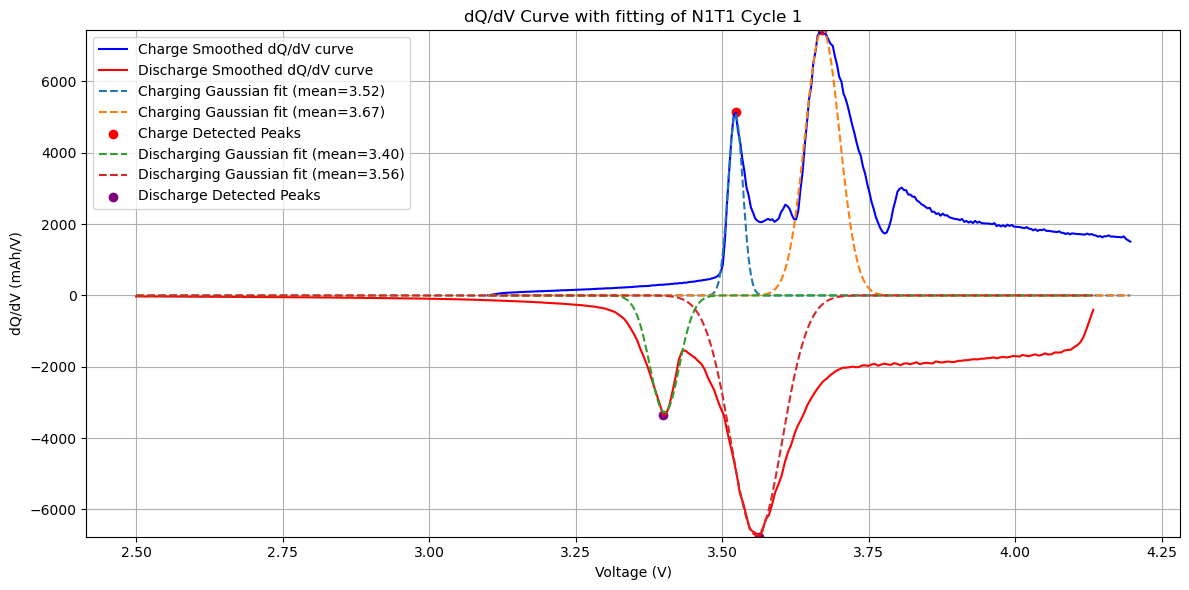

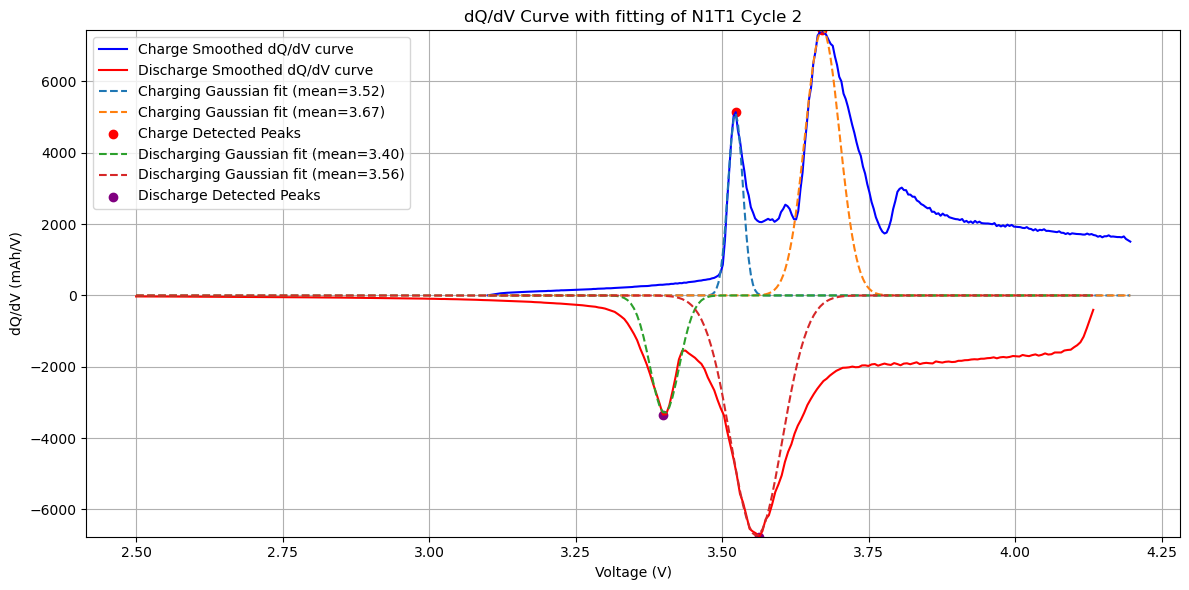

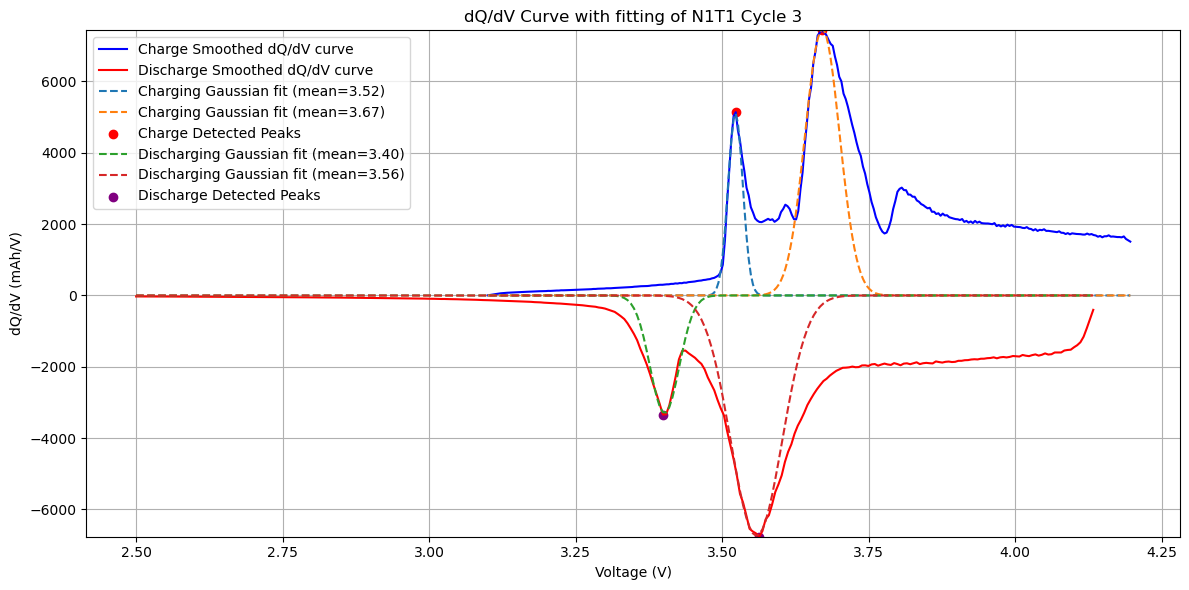

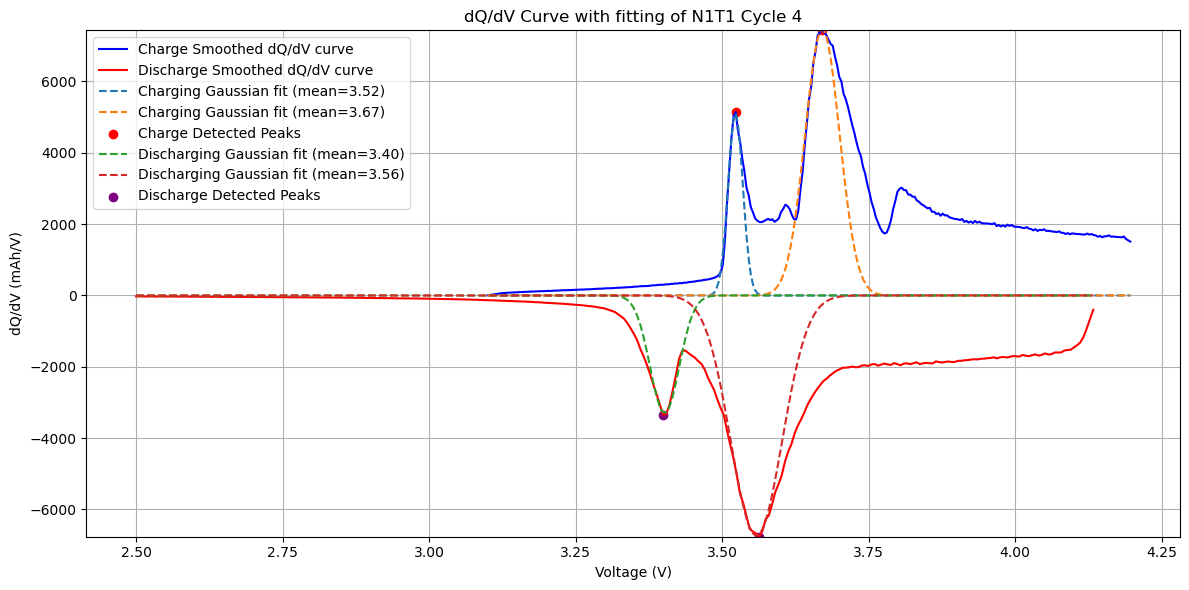

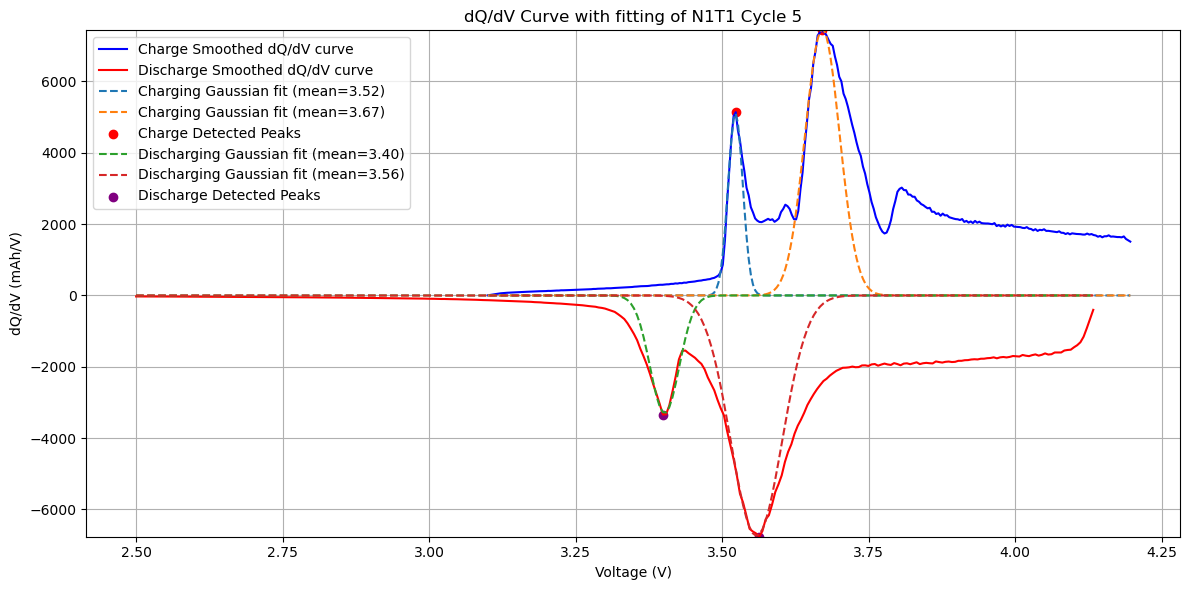

In [26]:
if 'peaks-fitting' in show_on_plot:
    for cycle_id in cycle_numbers:   
#---------------Gaussian Fitting based on Detected Peaks---------------
        Chg_gauss_params = []
        DChg_gauss_params = []  
        Chg_gauss_area = []
        DChg_gauss_area = []
            
        #---------------------------On Charging----------------------------
        for Chg_peak in Chg_peak_indices:
            # Take a small window around each peak for fitting
            Chg_x_peak = v_chg_smooth[max(0, Chg_peak - window_size):min(len(v_chg_smooth), Chg_peak + window_size)]
            Chg_y_peak = dqdv_chg_smooth[max(0, Chg_peak - window_size):min(len(v_chg_smooth), Chg_peak + window_size)]
    
            # Initial guesses for amp, mean, sigma
            Chg_amp_guess = dqdv_chg_smooth[Chg_peak]
            Chg_mean_guess = v_chg_smooth[Chg_peak]
            Chg_sigma_guess = 0.05
                
            try:
                Chg_popt, _ = curve_fit(gaussian, Chg_x_peak, Chg_y_peak, p0=[Chg_amp_guess, Chg_mean_guess, Chg_sigma_guess], maxfev=5000)
                Chg_area = Chg_popt[0] * Chg_popt[2] * np.sqrt(2 * np.pi)
                Chg_gauss_params.append(Chg_popt)  
                Chg_gauss_area.append(Chg_area)
            except RuntimeError:
                continue # Skip if fitting fails
                
        #--------------------------On Discharging--------------------------
        for DChg_peak in DChg_peak_indices:
            # Take a small window around each peak for fitting
            DChg_x_peak = v_dchg_smooth[max(0, DChg_peak - window_size):min(len(v_dchg_smooth), DChg_peak + window_size)]
            DChg_y_peak = dqdv_dchg_smooth[max(0, DChg_peak - window_size):min(len(v_dchg_smooth), DChg_peak + window_size)]
    
            # Initial guesses for amp, mean, sigma
            DChg_amp_guess = dqdv_dchg_smooth[DChg_peak]
            DChg_mean_guess = v_dchg_smooth[DChg_peak]
            DChg_sigma_guess = 0.5
                   
            # Fit Gaussian to each peak
            try:
                DChg_popt, _ = curve_fit(gaussian, DChg_x_peak, DChg_y_peak, p0=[DChg_amp_guess, DChg_mean_guess, DChg_sigma_guess], maxfev=5000)
                DChg_area = DChg_popt[0] * DChg_popt[2] * np.sqrt(2 * np.pi)
                DChg_gauss_params.append(DChg_popt)     
                DChg_gauss_area.append(DChg_area)
            except RuntimeError:
                continue # Skip if fitting fails
            
        #------------------Plotting Fitted Curve on dQ/dV------------------
        plt.figure(figsize=(12, 6))

        # Plot the smoothed dQ/dV curve
        plt.plot(v_chg_smooth, dqdv_chg_smooth, label='Charge Smoothed dQ/dV curve', color='blue')
        plt.plot(v_dchg_smooth, dqdv_dchg_smooth, label='Discharge Smoothed dQ/dV curve', color='red')
                
        # Plot each fitted Gaussian
        for Chg_params in Chg_gauss_params:
            plt.plot(v_chg_smooth, gaussian(v_chg_smooth, *Chg_params), '--', label=f'Charging Gaussian fit (mean={Chg_params[1]:.2f})')
                
        # Highlight the detected peaks
        plt.scatter(v_chg_smooth[Chg_peak_indices], dqdv_chg_smooth[Chg_peak_indices], color='red', label='Charge Detected Peaks')
    
        # Plot each fitted Gaussian
        for DChg_params in DChg_gauss_params:
            plt.plot(v_dchg_smooth, gaussian(v_dchg_smooth, *DChg_params), '--', label=f'Discharging Gaussian fit (mean={DChg_params[1]:.2f})')
    
        # Highlight the detected peaks
        plt.scatter(v_dchg_smooth[DChg_peak_indices], dqdv_dchg_smooth[DChg_peak_indices], color='purple', label='Discharge Detected Peaks')
    
        # Add labels, title, and legend
        plt.xlabel('Voltage (V)')
        plt.ylabel('dQ/dV (mAh/V)')
        plt.ylim(dqdv_dchg_smooth[DChg_peak_indices].min(), dqdv_chg_smooth[Chg_peak_indices].max())
        plt.title(f'dQ/dV Curve with fitting of {file_name} Cycle {cycle_id}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'{result_folder}/{file_name}/dQdV_fitting_{file_name}_Cycle_{cycle_id}.png', dpi=300)
        plt.show()

Lastly, compile all the fitted peaks properties and export it into CSV file. Preview of DataFrame (df_fitting) is shown on the following output.

In [27]:
if 'peaks-fitting' in show_on_plot:
    for cycle_id in cycle_numbers:       
        #-------------------Compiling Fitted Properties--------------------
        peak_no_Chg = 1
        for chg_popt in Chg_gauss_params:
            chg_popt = list(chg_popt)  # Convert to list for safe concatenation
            chg_area = chg_popt[0] * chg_popt[2] * np.sqrt(2 * np.pi)
            chg_label = peak_no_Chg
            peak_no_Chg += 1
            gaussian_results.append([cycle_id, 'Charge', chg_label, *chg_popt, chg_area])
                
        peak_no_DChg = 1
        for dchg_popt in DChg_gauss_params:
            dchg_popt = list(dchg_popt)  # Convert to list for safe concatenation
            dchg_area = dchg_popt[0] * dchg_popt[2] * np.sqrt(2 * np.pi)
            dchg_label = peak_no_DChg
            peak_no_DChg += 1
            gaussian_results.append([cycle_id, 'Discharge', dchg_label, *dchg_popt, dchg_area])

#--------------------------------Exporting---------------------------------     
# Export fitted peaks properties data to CSV
df_fitting = pd.DataFrame(gaussian_results, columns=['Cycle ID', 'Status', 'Peak No', 'Amplitude', 'Mean', 'Sigma', 'Area'])
df_fitting.to_csv(f'{result_folder}/{file_name}/df_fitting_{file_name}.csv', index=False)
print("Gaussian fitting properties saved successfully to",f'{result_folder}/{file_name}/df_fitting_{file_name}.csv')
pd.set_option('display.max_columns', None)  # Show all columns   
print('DataFrame df_fitting preview: ')
print(df_fitting.head())

Gaussian fitting properties saved successfully to DA_Result/N1T1/df_fitting_N1T1.csv
DataFrame df_fitting preview: 
   Cycle ID     Status  Peak No    Amplitude      Mean     Sigma        Area
0         1     Charge        1  5103.577170  3.522707 -0.012602 -161.215128
1         1     Charge        2  7463.770288  3.670959  0.029430  550.604835
2         1  Discharge        1 -3297.436448  3.401840 -0.024918  205.961144
3         1  Discharge        2 -6738.414907  3.558551  0.043787 -739.588905
4         2     Charge        1  5103.577170  3.522707 -0.012602 -161.215128
